### Import necessary dependencies

In [36]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms.functional as TF
from torchvision.models import vgg19
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import numpy as np
from tqdm import tqdm

### Configurations

In [37]:
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-4
num_epochs = 20
batch_size = 16
scale = 4
patch_size = (96, 96)
num_residual_blocks = 16

### Preprocessing

In [38]:
def image_to_patches(image, patch_size):
    channels, height, width = image.size()
    patch_height, patch_width = patch_size
    patches = []
    
    # Calculate padding needed for width and height
    pad_height = patch_height - height%patch_height
    pad_width = patch_width - width%patch_width
    
    # Apply the padding
    padded_image = F.pad(image, (0, pad_width, 0, pad_height))
    
    # start, stop, step
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            # the patch consist of all the channels, 
            patch = padded_image[:, y:y+patch_height, x:x+patch_width]
            patches.append(patch)
            
            
    return patches

In [39]:
def preprocess_images_in_folder(folder_path, scale, patch_size):
    
    processed_images = []
    
    for filename in tqdm(os.listdir(folder_path), desc="Processing images", colour='green') :
        image_path = os.path.join(folder_path, filename)
        
        input_image = cv2.imread(image_path)
        
        input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        
        # change cv2 BGR to RGB
        GT_tensor = torch.tensor(input_image_rgb, dtype=torch.float32).permute(2,0,1)/255
        
        
        GT_image_pil = Image.fromarray(input_image_rgb)
        LR_image = TF.resize(GT_image_pil, [GT_image_pil.size[1] // scale, GT_image_pil.size[0] // scale], interpolation=Image.BICUBIC)
        
        LR_tensor_resized = TF.resize(LR_image, [GT_tensor.shape[1], GT_tensor.shape[2]], interpolation=Image.BICUBIC)
        LR_tensor_resized = TF.to_tensor(LR_tensor_resized).float()
        
        LR_patches = image_to_patches(LR_tensor_resized, patch_size)
        GT_patches = image_to_patches(GT_tensor, patch_size)
        processed_images.extend(zip(LR_patches, GT_patches))
        
    return processed_images

In [40]:
def display_image(LR, GT):
    
    # Display Ground Truth Image
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(GT.permute(1,2,0))
    plt.title("Ground Truth (GT)")
    plt.axis('off')
    
    # Display the input image
    plt.subplot(1, 2, 1)
    plt.imshow(LR.permute(1, 2, 0))
    plt.title("Low Resolution (LR)")
    plt.axis('off')
    
    plt.show()

### Preprocessing training and test images

In [41]:
train_images_folder_path = 'data/Train'
test_images_set5_folder_path = 'data/Test/Set5'
test_images_set14_folder_path = 'data/Test/Set14'

processed_train_images = preprocess_images_in_folder(train_images_folder_path, scale, patch_size)
processed_test_set5_images = preprocess_images_in_folder(test_images_set5_folder_path, scale, patch_size)
processed_test_set14_images = preprocess_images_in_folder(test_images_set14_folder_path, scale, patch_size)

Processing images: 100%|██████████| 14/14 [00:00<00:00, 87.23it/s]


torch.Size([3, 96, 96])


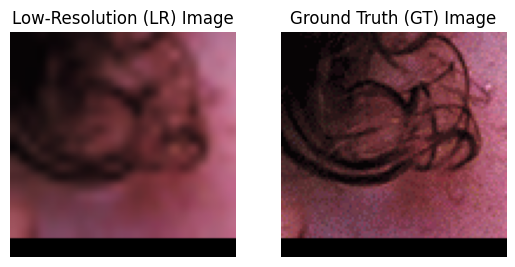

In [44]:
# Assuming processed_images is your list of LR and GT patches
random_pair = random.choice(processed_test_set5_images)
LR_patch, GT_patch = random_pair

# Plot LR image
plt.subplot(1, 2, 1)
plt.imshow(LR_patch.permute(1, 2, 0))  # Permute LR image dimensions to (height, width, channels) and plot
plt.title('Low-Resolution (LR) Image')
plt.axis('off')

print(LR_patch.size())
# Plot GT image
plt.subplot(1, 2, 2)
plt.imshow(GT_patch.permute(1, 2, 0))  # Assuming GT image is also in (height, width, channels) format
plt.title('Ground Truth (GT) Image')
plt.axis('off')

plt.show()

### Putting images in DataLoader

In [45]:
train_loader = DataLoader(processed_train_images, batch_size=batch_size)
test_set5_loader = DataLoader(processed_test_set5_images, batch_size=batch_size)
test_set14_loader = DataLoader(processed_test_set14_images, batch_size=batch_size)

### Defining Residual Block classes for Generator and Discriminator

In [46]:
class ResBlockGenerator(nn.Module):
    def __init__(self):
        super(ResBlockGenerator, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        self.batch_norm1 = nn.BatchNorm2d(64, momentum=0.5)
        self.p_relu = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        self.batch_norm2 = nn.BatchNorm2d(64, momentum=0.5)
        
    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.batch_norm1(out)
        out = self.p_relu(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        out += input_tensor
        return out

### Defining Generator model

In [47]:
class Generator(nn.Module):
    def __init__(self, num_residual_blocks = num_residual_blocks):
        super(Generator, self).__init__()
        # Pre residual layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding='same')
        self.p_relu1 = nn.PReLU()
        
        self.residual_blocks = nn.Sequential(
            *[ResBlockGenerator() for _ in range(num_residual_blocks)]
        )
        
        # Post residual layers
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        self.batch_norm = nn.BatchNorm2d(64, momentum=0.5)
        
        # Upsampling layers
        self.upsample1 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding='same'),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        
        self.upsample2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding='same'),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        
        # Output convolutional layer
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding='same')
        
    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.p_relu1(out)
        input_residual_tensor = out.clone()
        
        for res_block in self.residual_blocks:
            out = res_block(out)
            
        out = self.conv2(out)
        out = self.batch_norm(out)
        out += input_residual_tensor
        
        out = self.upsample1(out)
        out = self.upsample2(out)
            
        out = self.conv3(out)
        return out
        

### Defining Discriminator model

In [48]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channel,out_channel, strides = 1, padding_same=True):
        super(DiscriminatorBlock, self).__init__()
        
        if padding_same:
            self.padding = 'same'
        else:
            self.padding = 0
            
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding=self.padding)
        self.batch_normalization = nn.BatchNorm2d(out_channel, momentum=0.8)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, input_tensor):
        out = self.conv(input_tensor)
        out = self.batch_normalization(out)
        out = self.leaky_relu(out)
        return out

In [49]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding='same')
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        
        self.block_with_batch_norm = nn.Sequential(
            DiscriminatorBlock(64, 64, strides=2, padding_same=False),
            DiscriminatorBlock(64, 128),
            DiscriminatorBlock(128, 128,strides=2, padding_same=False),
            DiscriminatorBlock(128, 256),
            DiscriminatorBlock(256, 256, strides=2, padding_same=False),
            DiscriminatorBlock(256, 512, ),
            DiscriminatorBlock(512, 512, strides=2, padding_same=False)
        )
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512 * 5 * 5, 1024)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()
        
        
        
    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.leaky_relu1(out)
        out = self.block_with_batch_norm(out)
        out = self.flatten(out)
        out = self.dense1(out)
        out = self.leaky_relu2(out)
        out = self.dense2(out)
        out = self.sigmoid(out)
        return out

### Creating VGG loss function

In [50]:
#phi_2,2, after 2nd activation, but before the 2nd max pooling

class VGG19Loss(nn.Module):
    def __init__(self, layer_index=9):
        super(VGG19Loss, self).__init__()
        vgg19_model = vgg19(weights='DEFAULT')
        
        # vgg19_model.features.children() returns an iterator over each individual layer
        # list() converts the iterator into a Python list
        # [:layer_index + 1] slices the list up to and including the layer at layer_index
        # * is the unpacking operator, which makes the list elements suitable to be passed to nn.Sequential 
        self.features = nn.Sequential(*list(vgg19_model.features.children())[:layer_index + 1])
        
        # Make sure no updating of the parameters occur
        for param in self.features.parameters():
            param.requires_grad = False
            
        self.criterion = nn.MSELoss()
        
    def forward(self, sr, hr):
        sr_features = self.features(sr)
        hr_features = self.features(hr)
        
        loss = self.criterion(sr_features, hr_features)
        
        return loss

### Defining generator, discriminator and VGG loss

In [51]:
generator = Generator(num_residual_blocks=16)
discriminator = Discriminator()
vgg_loss = VGG19Loss()

generator.to(device)
discriminator.to(device)
vgg_loss.to(device)

VGG19Loss(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (criterion): MSELoss()
)

### Defining optimizers and loss functions

In [52]:
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))

scheduler_generator = ReduceLROnPlateau(optimizer_generator, mode='min', factor=0.5, patience=5, verbose=True)
scheduler_discriminator = ReduceLROnPlateau(optimizer_discriminator, mode='min', factor=0.5, patience=5, verbose=True)

adversarial_criterion = nn.BCELoss()
pixel_criterion = nn.MSELoss()

c:\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Training loop

In [53]:
for epoch in range(num_epochs):
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch}/{num_epochs}', position=0, leave=True) as pbar_epoch:
        for i, (imgs_lr, imgs_hr) in enumerate(train_loader):
            
            imgs_lr = imgs_lr.to(device)
            imgs_hr = imgs_hr.to(device)
        
            # Training the generator
            fake_hr = generator(imgs_lr)
            fake_hr_resized = F.interpolate(fake_hr, size=(96, 96), mode='bilinear', align_corners=False)
        
            optimizer_generator.zero_grad()
        
            real_labels = torch.ones((imgs_hr.size(0), 1), requires_grad=False).to(device)
            fake_labels = torch.zeros((imgs_hr.size(0), 1), requires_grad=False).to(device)
        
            # Training the discriminator with real images
            outputs_real = discriminator(imgs_hr)
            loss_real = adversarial_criterion(outputs_real, real_labels)
        
            # Training discriminator with fake images
            outputs_fake = discriminator(fake_hr_resized.detach())
            loss_fake = adversarial_criterion(outputs_fake, fake_labels)
        
            loss_discriminator = (loss_real + loss_fake)/2
            loss_discriminator.backward()
            optimizer_discriminator.step()
        
            optimizer_generator.zero_grad()
        
            outputs_fake = discriminator(fake_hr_resized)
            adversarial_loss = adversarial_criterion(outputs_fake, real_labels)
        
            pixel_loss = pixel_criterion(fake_hr_resized, imgs_hr)
        
            perceptual_loss = vgg_loss(fake_hr_resized, imgs_hr)
        
            perceptual_adversarial_loss = perceptual_loss + 0.001 * adversarial_loss
        
            total_loss = pixel_loss + perceptual_adversarial_loss
            total_loss.backward()
            optimizer_generator.step()
            
            pbar_epoch.update(1)
            pbar_epoch.set_postfix({'Discriminator loss': loss_discriminator.item(), 'Generator loss': total_loss.item()})
            
        scheduler_generator.step(total_loss)
        scheduler_discriminator.step(loss_discriminator)
            
    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {loss_discriminator.item():.4f}] [G loss: {total_loss.item():.4f}] "
              f"[Pixel loss: {pixel_loss.item():.4f}] [VGG loss: {perceptual_loss.item():.4f}] "
              f"[Adversarial loss: {adversarial_loss.item():.4f}]")

Epoch 0/20: 100%|██████████| 125/125 [34:07<00:00, 16.38s/it, Discriminator loss=42, Generator loss=1.41]   


[Epoch 1/20] [D loss: 42.0076] [G loss: 1.4125] [Pixel loss: 0.0381] [VGG loss: 1.3744] [Adversarial loss: 0.0000]


Epoch 1/20: 100%|██████████| 125/125 [34:04<00:00, 16.35s/it, Discriminator loss=36, Generator loss=1.32]   


[Epoch 2/20] [D loss: 36.0319] [G loss: 1.3154] [Pixel loss: 0.0264] [VGG loss: 1.2883] [Adversarial loss: 0.6479]


Epoch 2/20: 100%|██████████| 125/125 [33:34<00:00, 16.12s/it, Discriminator loss=44.5, Generator loss=1.26] 


[Epoch 3/20] [D loss: 44.5492] [G loss: 1.2580] [Pixel loss: 0.0208] [VGG loss: 1.2372] [Adversarial loss: 0.0000]


Epoch 3/20: 100%|██████████| 125/125 [33:14<00:00, 15.96s/it, Discriminator loss=38.7, Generator loss=1.24] 


[Epoch 4/20] [D loss: 38.6891] [G loss: 1.2427] [Pixel loss: 0.0172] [VGG loss: 1.2242] [Adversarial loss: 1.2842]


Epoch 4/20: 100%|██████████| 125/125 [33:23<00:00, 16.03s/it, Discriminator loss=50, Generator loss=1.22]  


[Epoch 5/20] [D loss: 50.0000] [G loss: 1.2179] [Pixel loss: 0.0142] [VGG loss: 1.2038] [Adversarial loss: 0.0000]


Epoch 5/20: 100%|██████████| 125/125 [33:32<00:00, 16.10s/it, Discriminator loss=50, Generator loss=1.2]  


[Epoch 6/20] [D loss: 50.0000] [G loss: 1.1954] [Pixel loss: 0.0132] [VGG loss: 1.1822] [Adversarial loss: 0.0000]


Epoch 6/20: 100%|██████████| 125/125 [33:03<00:00, 15.87s/it, Discriminator loss=50, Generator loss=1.17] 


[Epoch 7/20] [D loss: 50.0000] [G loss: 1.1657] [Pixel loss: 0.0121] [VGG loss: 1.1535] [Adversarial loss: 0.0000]


Epoch 7/20: 100%|██████████| 125/125 [32:55<00:00, 15.80s/it, Discriminator loss=50, Generator loss=1.15] 


[Epoch 8/20] [D loss: 50.0000] [G loss: 1.1493] [Pixel loss: 0.0124] [VGG loss: 1.1369] [Adversarial loss: 0.0000]


Epoch 8/20: 100%|██████████| 125/125 [32:38<00:00, 15.66s/it, Discriminator loss=50, Generator loss=1.15] 


[Epoch 9/20] [D loss: 50.0000] [G loss: 1.1494] [Pixel loss: 0.0108] [VGG loss: 1.1386] [Adversarial loss: 0.0000]


Epoch 9/20: 100%|██████████| 125/125 [32:57<00:00, 15.82s/it, Discriminator loss=50, Generator loss=1.13] 


[Epoch 10/20] [D loss: 50.0000] [G loss: 1.1344] [Pixel loss: 0.0100] [VGG loss: 1.1244] [Adversarial loss: 0.0000]


Epoch 10/20: 100%|██████████| 125/125 [32:33<00:00, 15.63s/it, Discriminator loss=50, Generator loss=1.15] 


[Epoch 11/20] [D loss: 50.0000] [G loss: 1.1515] [Pixel loss: 0.0087] [VGG loss: 1.1428] [Adversarial loss: 0.0000]


Epoch 11/20: 100%|██████████| 125/125 [33:52<00:00, 16.26s/it, Discriminator loss=50, Generator loss=1.12] 


[Epoch 12/20] [D loss: 50.0000] [G loss: 1.1186] [Pixel loss: 0.0089] [VGG loss: 1.1097] [Adversarial loss: 0.0000]


Epoch 12/20: 100%|██████████| 125/125 [34:19<00:00, 16.47s/it, Discriminator loss=50, Generator loss=1.1]  


[Epoch 13/20] [D loss: 50.0000] [G loss: 1.1019] [Pixel loss: 0.0083] [VGG loss: 1.0936] [Adversarial loss: 0.0000]


Epoch 13/20: 100%|██████████| 125/125 [33:50<00:00, 16.25s/it, Discriminator loss=50, Generator loss=1.09] 


[Epoch 14/20] [D loss: 50.0000] [G loss: 1.0948] [Pixel loss: 0.0081] [VGG loss: 1.0867] [Adversarial loss: 0.0000]


Epoch 14/20: 100%|██████████| 125/125 [34:02<00:00, 16.34s/it, Discriminator loss=50, Generator loss=1.09] 


[Epoch 15/20] [D loss: 50.0000] [G loss: 1.0928] [Pixel loss: 0.0075] [VGG loss: 1.0853] [Adversarial loss: 0.0000]


Epoch 15/20: 100%|██████████| 125/125 [33:55<00:00, 16.28s/it, Discriminator loss=50, Generator loss=1.07] 


[Epoch 16/20] [D loss: 50.0000] [G loss: 1.0687] [Pixel loss: 0.0071] [VGG loss: 1.0616] [Adversarial loss: 0.0000]


Epoch 16/20: 100%|██████████| 125/125 [33:50<00:00, 16.24s/it, Discriminator loss=50, Generator loss=1.06] 


[Epoch 17/20] [D loss: 50.0000] [G loss: 1.0555] [Pixel loss: 0.0068] [VGG loss: 1.0486] [Adversarial loss: 0.0000]


Epoch 17/20: 100%|██████████| 125/125 [33:43<00:00, 16.19s/it, Discriminator loss=50, Generator loss=1.06] 


[Epoch 18/20] [D loss: 50.0000] [G loss: 1.0587] [Pixel loss: 0.0067] [VGG loss: 1.0521] [Adversarial loss: 0.0000]


Epoch 18/20: 100%|██████████| 125/125 [34:01<00:00, 16.33s/it, Discriminator loss=50, Generator loss=1.06] 


[Epoch 19/20] [D loss: 50.0000] [G loss: 1.0581] [Pixel loss: 0.0064] [VGG loss: 1.0517] [Adversarial loss: 0.0000]


Epoch 19/20: 100%|██████████| 125/125 [34:00<00:00, 16.32s/it, Discriminator loss=50, Generator loss=1.06] 

[Epoch 20/20] [D loss: 50.0000] [G loss: 1.0575] [Pixel loss: 0.0061] [VGG loss: 1.0514] [Adversarial loss: 0.0000]


In [54]:
generator_best = generator.state_dict()
generator.load_state_dict(generator_best)
torch.save(generator.state_dict(), 'SRGAN.pth')

In [56]:
# Function to process and save image
def process_and_save_image(input_image_path, output_image_path):
    input_image = cv2.imread(input_image_path)  # Read input image

    # Convert from BGR to RGB
    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        
    # Convert image to tensor and normalize to [0, 1]
    input_tensor = torch.tensor(input_image_rgb, dtype=torch.float32).permute(2, 0, 1) / 255.0
    
    # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        SR_tensor = generator(input_tensor)

    # Post-process SR tensor
    SR_tensor = SR_tensor.squeeze().permute(1, 2, 0).cpu().numpy()  # Remove batch dimension, permute to HWC
    SR_tensor = np.clip(SR_tensor * 255.0, 0, 255).astype(np.uint8)  # Rescale to [0, 255] and convert to uint8

    # Resize the output image by reducing it to one-fourth of its original dimensions
    SR_tensor_resized = cv2.resize(SR_tensor, (SR_tensor.shape[1] // 4, SR_tensor.shape[0] // 4), interpolation=cv2.INTER_LINEAR)

    # Save the super-resolved image
    cv2.imwrite(output_image_path, cv2.cvtColor(SR_tensor_resized, cv2.COLOR_RGB2BGR))
    print(f"Processed and saved: {output_image_path}")

# Create output directory if it doesn't exist
input_dir = 'data/Test/Set14'
output_dir = 'results/Set14'
os.makedirs(output_dir, exist_ok=True)

# Process all images in the specified input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.bmp'):
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)
        process_and_save_image(input_image_path, output_image_path)

Processed and saved: results/Set14\baboon.bmp
Processed and saved: results/Set14\barbara.bmp
Processed and saved: results/Set14\bridge.bmp
Processed and saved: results/Set14\coastguard.bmp
Processed and saved: results/Set14\comic.bmp
Processed and saved: results/Set14\face.bmp
Processed and saved: results/Set14\flowers.bmp
Processed and saved: results/Set14\foreman.bmp
Processed and saved: results/Set14\lenna.bmp
Processed and saved: results/Set14\man.bmp
Processed and saved: results/Set14\monarch.bmp
Processed and saved: results/Set14\pepper.bmp
Processed and saved: results/Set14\ppt3.bmp
Processed and saved: results/Set14\zebra.bmp
